In [4]:
import pandas as pd
import numpy as np
import onnxruntime as rt
import onnx
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import xgboost as xgb
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
)
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from aif360.sklearn.datasets import fetch_compas
from aif360.sklearn.metrics import disparate_impact_ratio, consistency_score, generalized_entropy_error
from aif360.sklearn.detectors import bias_scan
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

In [4]:
model = xgb.XGBClassifier(max_depth=25, n_estimators = 200)

pipeline = Pipeline([
    ('standard_scaler', StandardScaler()), 
    ('model', model)
])

param_grid = {
    'model__max_depth': [20, 25, 30],
    'model__n_estimators': [175, 200]
}

grid = HalvingGridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc', verbose=10)# 




In [8]:
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
selector = VarianceThreshold()
pipeline = Pipeline(steps=[('feature selection', selector), ('classification', classifier)])

In [24]:
# Let's load the dataset
data = pd.read_csv('data/synth_data_for_training.csv')

# Let's specify the features and the target
y = data['checked']
X = data.drop(['checked'], axis=1)
X = X.astype(np.float32)

# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
print(X_train.shape, X_test.shape)

(2529, 315) (10116, 315)


In [92]:
def intoBinary(data, attribute, split):
    sorted_data = data.sort_values(by=attribute)
    split_index = int(len(sorted_data) * split)

    split_threshold = sorted_data.iloc[split_index][attribute]
    print("boundary = ", split_threshold)
    binary_attribute = pd.Series(0, index=data.index)
    binary_attribute[sorted_data[attribute] > split_threshold] = 1

    data[attribute] = binary_attribute
    return data
  
  
def showDistributionOfpred(data_frame, feature, binary=True):
  z = data_frame.loc[(data_frame['checked'] == 0), :]
  s = data_frame.loc[(data_frame['checked'] == 1), :]
  print(z.shape)
  print(s.shape)

  z_m = z[feature].max()
  s_m = s[feature].max()
  
  if binary:
   
    plt.hist([z[feature], s[feature]], bins=[0, 1, 2], stacked=True, label=['non checked', 'checked'], rwidth=0.2)
  else:
    z_m = z[feature].max()
    s_m = s[feature].max()
    m = int(max(z_m, s_m))
    print("max", m)
    bin_steps = max(1, int(m / 100))
    
    print("bin steps", bin_steps)
    bins = range(0, m + bin_steps, bin_steps)
    bins = [0, 0.5, 1.5, 2,5]
  
  
    plt.hist([z[feature], s[feature]], stacked=True, bins=bins, label=['non checked', 'checked'])
    
  # Add labels and title
  plt.xlabel(feature)
  plt.ylabel('Frequency')
  plt.title('Stacked Histogram')
  # Add legend
  plt.legend()
  # Show plot
  plt.show()



def test_model(model, x_testing, y_testing, value_dic, accuracy=True, roc_auc=True, f1=True,
               precision=True, recall=True, conf_matrix=True, cross_validate=False, roc_curves=True,
               dis_imp=True, ba_rat=True, consist=True, mean_diff=True, num_neg=True, rich=True, e_d_f=True, s_p_d=True, detector=False, dis_plots=False):

  
  
  predictions = model.run(None, {'X': x_testing.values.astype(np.float32)})
  y_pred = predictions[0]
  probabilities = [d[1] for d in predictions[1]]
  
  assert y_pred.shape[0] == y_testing.shape[0]
  print(type(y_pred))
  print(type(y_testing))
  
  preds = pd.Series(y_pred)
  
  data_frame = pd.concat([x_testing.reset_index(drop=True), pd.DataFrame(preds, columns=['checked'])], axis=1)
  data_true = pd.concat([x_testing, pd.DataFrame(y_testing, columns=['checked'])], axis=1)
  # print(data_frame
  # print("dataframe ", data_frame.shape)
  # print("data true ", data_true.shape)
  # print("y_labels ", y_testing.shape)
  # print("y_pred ", y_pred.shape)
  # print("x_testing ", x_testing.shape)
  pd.set_option('display.max_columns', None)
  # # pd.set_option('display.max_columns', None)
  # column_names = data_frame.columns.tolist()

  # # Print out all the keys (column names) of the dataframe individually
  # for col in column_names:
  #     print(col)

  
  if dis_plots:
    # showDistributionOfpred(data_frame, 'adres_dagen_op_adres', binary=False)
    # showDistributionOfpred(data_true, 'adres_dagen_op_adres', binary=False)
    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_dagen_sinds_taaleis', binary=False)
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_dagen_sinds_taaleis', binary=False)
    # showDistributionOfpred(data_frame, 'persoon_leeftijd_bij_onderzoek', binary=False)
    # showDistributionOfpred(data_true, 'persoon_leeftijd_bij_onderzoek', binary=False)
    # showDistributionOfpred(data_frame, 'persoon_geslacht_vrouw')
    # showDistributionOfpred(data_true, 'persoon_geslacht_vrouw')
    # showDistributionOfpred(data_frame, 'adres_aantal_brp_adres', binary=False)
    # showDistributionOfpred(data_true, 'adres_aantal_brp_adres', binary=False)
    # showDistributionOfpred(data_frame, 'competentie_leren')
    # showDistributionOfpred(data_true, 'competentie_leren')
    # showDistributionOfpred(data_frame, 'relatie_kind_huidige_aantal', binary=False)
    # showDistributionOfpred(data_true, 'relatie_kind_huidige_aantal', binary=False)
    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_taaleis_voldaan', binary=False)
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_taaleis_voldaan', binary=False) 0.055
    # showDistributionOfpred(data_frame, 'instrument_ladder_huidig_werk_re_integratie')
    # showDistributionOfpred(data_true, 'instrument_ladder_huidig_werk_re_integratie') #0.04
    # showDistributionOfpred(data_frame, 'contacten_onderwerp_boolean_taaleis___voldoet')
    # showDistributionOfpred(data_true, 'contacten_onderwerp_boolean_taaleis___voldoet') # 0.0576
    # showDistributionOfpred(data_frame, 'contacten_onderwerp_boolean_beoordelen_taaleis') #0.057
    # showDistributionOfpred(data_true, 'contacten_onderwerp_boolean_beoordelen_taaleis') #0.057

    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_taaleis_voldaan') # 0.058
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_taaleis_voldaan') 
    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_spreektaal')
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_spreektaal') 
    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_spreektaal_anders')
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_spreektaal_anders')
    # showDistributionOfpred(data_frame, 'belemmering_hist_taal') #0.58
    # showDistributionOfpred(data_true, 'belemmering_hist_taal')
    showDistributionOfpred(data_frame, 'typering_hist_inburgeringsbehoeftig')
    showDistributionOfpred(data_true, 'typering_hist_inburgeringsbehoeftig') #0.007
    
    


    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_nl_spreken3')
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_nl_spreken3') #0.007
    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_nl_spreken2') # 0.005
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_nl_spreken2')    
    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_nl_spreken3') #0.054
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_nl_spreken3')
    
    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_nl_lezen3') 0.009
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_nl_lezen3')
    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_nl_lezen4') 0. 0257
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_nl_lezen4')    
    
    
    
    
    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_nl_begrijpen3') -0.009
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_nl_begrijpen3')
    
    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_nl_schrijvenfalse')
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_nl_schrijvenfalse') #0.0113
    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_nl_schrijven1')
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_nl_schrijven1') #0.0188
    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_nl_schrijven2')
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_nl_schrijven2')    #0.003
    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_nl_schrijven3')
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_nl_schrijven3') -0.006
    # showDistributionOfpred(data_frame, 'persoonlijke_eigenschappen_nl_schrijvenfalse')
    # showDistributionOfpred(data_true, 'persoonlijke_eigenschappen_nl_schrijvenfalse') 0.044


  ####
  # Alter this code manually to check for certain data groups have algorithmic bias.
  # Continous features have to be made binary by creating a precentile boundary
  ####

  #In order to seperate continious data into privelidge and unprivalidge, use this call to make it binary
  data_frame = intoBinary(data_frame, 'persoonlijke_eigenschappen_dagen_sinds_taaleis', 0.2) #This line turns it all binary
  data_frame = intoBinary(data_frame, 'adres_dagen_op_adres', 0.2) #This line turns it all binary
  data_frame = intoBinary(data_frame, 'persoon_leeftijd_bij_onderzoek', 0.2) #This line turns it all binary
  privileged_groups = [{'adres_dagen_op_adres': 0}]  # Privileged group for 'persoon_geslacht_vrouw'
  unprivileged_groups = [{'adres_dagen_op_adres': 1}]  # Unprivileged group for 'persoon_geslacht_vrouw'
  
  # privileged_groups = [{'persoonlijke_eigenschappen_taaleis_voldaan': 1}, ]  
  # unprivileged_groups = [{'persoonlijke_eigenschappen_taaleis_voldaan': 0}, {'persoonlijke_eigenschappen_taaleis_voldaan': 2}] 
  privileged_groups = [{'contacten_onderwerp_boolean_taaleis___voldoet': 1}]  
  unprivileged_groups = [{'contacten_onderwerp_boolean_taaleis___voldoet': 0}, {'contacten_onderwerp_boolean_taaleis___voldoet': 2}]   
  # privileged_groups = [{'contacten_onderwerp_boolean_beoordelen_taaleis': 1}]  
  # unprivileged_groups = [{'contacten_onderwerp_boolean_beoordelen_taaleis': 0}, {'contacten_onderwerp_boolean_beoordelen_taaleis': 2}] 
  # privileged_groups = [{'persoon_geslacht_vrouw': 0}]  
  # unprivileged_groups = [{'persoon_geslacht_vrouw': 1}] 
  # privileged_groups = [{'persoonlijke_eigenschappen_taaleis_voldaan': 0}]  
  # unprivileged_groups = [{'persoonlijke_eigenschappen_taaleis_voldaan': 1}, {'persoonlijke_eigenschappen_taaleis_voldaan': 2}] 

  privileged_groups = [{'persoonlijke_eigenschappen_nl_schrijven3': 1}]  # Privileged group for 'persoon_geslacht_vrouw'
  unprivileged_groups = [{'persoonlijke_eigenschappen_nl_schrijven3': 0}]  # Unprivileged group for 'persoon_geslacht_vrouw'

  # privileged_groups = [{'persoonlijke_eigenschappen_dagen_sinds_taaleis': 0}]
  # unprivileged_groups = [{'persoonlijke_eigenschappen_dagen_sinds_taaleis': 1}] 0.0257

  # privileged_groups = [{'persoonlijke_eigenschappen_dagen_sinds_taaleis': 0, 'persoon_geslacht_vrouw': 0}]
  # unprivileged_groups = [{'persoonlijke_eigenschappen_dagen_sinds_taaleis': 1, 'persoon_geslacht_vrouw': 1},
  #  {'persoon_geslacht_vrouw': 1}, {'persoonlijke_eigenschappen_dagen_sinds_taaleis': 1}]
  # privileged_groups = [{'persoon_leeftijd_bij_onderzoek': 1, 'contacten_onderwerp_boolean_beoordelen_taaleis': 1}]
  # unprivileged_groups = [{'persoon_leeftijd_bij_onderzoek': 1, 'contacten_onderwerp_boolean_beoordelen_taaleis': 1},
  #  {'persoon_geslacht_vrouw': 1}, {'persoonlijke_eigenschappen_dagen_sinds_taaleis': 1}]
  
  



  bld = BinaryLabelDataset(df=data_frame,
                  favorable_label=0,
                  unfavorable_label=1,
                  label_names=['checked'],
                  unprivileged_protected_attributes=[[0]],
                  privileged_protected_attributes=[[1]],
                  # unprivileged_protected_attributes=[[1], [1]],
                  # privileged_protected_attributes=[[0], [0]],
                  protected_attribute_names=['persoonlijke_eigenschappen_nl_schrijven3'],
                  # protected_attribute_names=['persoon_geslacht_vrouw', 'persoonlijke_eigenschappen_dagen_sinds_taaleis'],
          )

  bld.validate_dataset()
  print(bld.protected_attribute_names)
  stats_table = []
  metric = BinaryLabelDatasetMetric(bld, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)

  if(dis_imp):
    disparate_impact = metric.disparate_impact()
    print("Disparate Impact:", disparate_impact)
    stats_table.append(["Disparate impact", disparate_impact])
    if "Disparate Impact" not in value_dic:
      value_dic["Disparate Impact"] = [disparate_impact]
    else:
      value_dic["Disparate Impact"].append(disparate_impact)
      

  if(ba_rat):
    base_rate = metric.base_rate()
    print("Base Rate:", base_rate)
    stats_table.append(["Base Rate", base_rate])
    if "Base Rate" not in value_dic:
      value_dic["Base Rate"] = [base_rate]
    else:
      value_dic["Base Rate"].append(base_rate)

  if(consist):
    consistency = metric.consistency(n_neighbors=3)
    print("Consistency:", consistency)
    if len(consistency) > 1:
      print("Warning: don't understand why / when this happens but consoistency is a list of values. Taking the first one.")
    stats_table.append(["Consistency", consistency[0]])
    if "Consistency" not in value_dic:
      value_dic["Consistency"] = [consistency[0]]
    else:
      value_dic["Consistency"].append(consistency[0])

  if(mean_diff):
    mean_difference = metric.mean_difference()
    print("Mean Difference:", mean_difference)
    stats_table.append(["Mean Difference", mean_difference])
    if "Mean Difference" not in value_dic:
      value_dic["Mean Difference"] = [mean_difference]
    else:
      value_dic["Mean Difference"].append(mean_difference)

  if(num_neg):
    num_negatives = metric.num_negatives(privileged=None)
    print("Number of Negatives:", num_negatives)
    stats_table.append(["Number of Negatives", num_negatives])
    if "Number of Negatives" not in value_dic:
      value_dic["Number of Negatives"] = [num_negatives]
    else:
      value_dic["Number of Negatives"].append(num_negatives)

  if(e_d_f):
    emp_diff_fair = metric.smoothed_empirical_differential_fairness(concentration=1.0)
    print("Smoothed Empirical Differential Fairness:", emp_diff_fair)
    stats_table.append(["Smoothed Empirical Differential Fairness", emp_diff_fair])
    if "Smoothed Empirical Differential Fairness" not in value_dic:
      value_dic["Smoothed Empirical Differential Fairness"] = [emp_diff_fair]
    else:
      value_dic["Smoothed Empirical Differential Fairness"].append(emp_diff_fair)

  if(s_p_d):
    stat_par_diff = metric.statistical_parity_difference()
    print("Statistical Parity Difference:", stat_par_diff)
    stats_table.append(["Statistical Parity Difference", stat_par_diff])
    if "Statistical Parity Difference" not in value_dic:
      value_dic["Statistical Parity Difference"] = [stat_par_diff]
    else:
      value_dic["Statistical Parity Difference"].append(stat_par_diff)

  if(rich):
    rich_subgroup = metric.rich_subgroup(tuple(y_pred))
    print("Rich Subgroup:", rich_subgroup)
    stats_table.append(["Rich Subgroup", rich_subgroup])
    if "Rich Subgroup" not in value_dic:
      value_dic["Rich Subgroup"] = [rich_subgroup]
    else:
      value_dic["Rich Subgroup"].append(rich_subgroup)



  if accuracy:
      acc = accuracy_score(y_testing, y_pred)
      print(f'Accuracy:  {acc}')
      stats_table.append(["Accuracy", acc])
      if "Accuracy" not in value_dic:
        value_dic["Accuracy"] = [acc]
      else:
        value_dic["Accuracy"].append(acc)

  # ROC AUC
  if roc_auc:
      roc_auc_value = roc_auc_score(y_testing, probabilities)
      print(f'ROC AUC:   {roc_auc_value}')
      stats_table.append(["ROC AUC", roc_auc_value])
      if "" not in value_dic:
        value_dic["ROC AUC"] = [roc_auc_value]
      else:
        value_dic["ROC AUC"].append(roc_auc_value)

  # F1 Score
  if f1:
      f1_value = f1_score(y_testing, y_pred)
      print(f'F1 Score:  {f1_value}')
      stats_table.append(["F1 Score", f1_value])
      if "" not in value_dic:
        value_dic["F1 Score"] = [f1_value]
      else:
        value_dic["F1 Score"].append(f1_value)

  # Precision
  if precision:
      precision_value = precision_score(y_testing, y_pred)
      print(f'Precision: {precision_value}')
      stats_table.append(["Precision", precision_value])
      if "" not in value_dic:
        value_dic["Precision"] = [precision_value]
      else:
        value_dic["Precision"].append(precision_value)

  # Recall
  if recall:
      recall_value = recall_score(y_testing, y_pred)
      print(f'Recall:    {recall_value}')
      stats_table.append(["Recall", recall_value])
      if "" not in value_dic:
        value_dic["Recall"] = [recall_value]
      else:
        value_dic["Recall"].append(recall_value)

  # Confusion Matrix
  if conf_matrix:
      print('Confusion Matrix:')
      cm = confusion_matrix(y_testing, y_pred)
      stats_table.append(["Confusion Matrix", cm])
      if "Confusion Matrix" not in value_dic:
        value_dic["Confusion Matrix"] = [cm]
      else:
        value_dic["Confusion Matrix"].append(cm)

  # Cross-Validation Scores
  if cross_validate:
      cv_scores = cross_val_score(model, X, y, cv=5)
      print("Cross-Validation Scores:", cv_scores)
      stats_table.append(["Cross-Validation Scores", cv_scores])
      if "Cross-Validation Scores" not in value_dic:
        value_dic["Cross-Validation Scores"] = [cv_scores]
      else:
        value_dic["Cross-Validation Scores"].append(cv_scores)

  if detector:
    subset, score = bias_scan(x_testing, y_testing, pd.DataFrame(y_pred), mode='binary')
    print(score)
    print(subset)

  if(roc_curves):
    y_scores = probabilities
    fpr, tpr, thresholds = roc_curve(y_testing, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
  return stats_table

In [95]:
# Let's load the model
new_session = rt.InferenceSession("model_2.onnx")

# Let's predict the target
y_pred_onnx2 =  new_session.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx2[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

Accuracy of the ONNX model:  0.9820086990905497


In [20]:
X = pd.read_csv('data/synth_data_for_training.csv')
#Split disjoint in 5 splits
def getSplitsDisjoint(data, n):
    list = []
    listT = []
    kf = KFold(n, shuffle=True)
    folds = kf.split(data)
    for (trainfold, testfold) in folds:
        list.append(X.iloc[testfold])
        listT.append(X.iloc[trainfold])
    return list, listT

#Random test splits overlapping
def getSplits(data, n, ratio):
    list = []
    for i in range(0, n):
        train, test = train_test_split(data, test_size=ratio, shuffle=True)
        list.append(test)
    return list
test_splits, train_splits = getSplitsDisjoint(X, 5)
# test_splits = getSplits(X, 5, 0.5)




In [93]:
dict = {}
for i in range(len(test_splits)):
    pipeline.fit(train_splits[i].drop(['checked'], axis=1), train_splits[i]['checked'])
    # Let's convert the model to ONNX
    onnx_model = convert_sklearn(
        pipeline, initial_types=[('X', FloatTensorType((None, X.shape[1])))],
        target_opset=12)

    # Let's check the accuracy of the converted model
    sess = rt.InferenceSession(onnx_model.SerializeToString())
    test_model(sess, train_splits[i].drop(['checked'], axis=1), train_splits[i]['checked'], dict, consist=False, dis_plots=False, roc_curves=False, e_d_f=False)
    
print(dict)
# test_model(new_session, X_test, y_test, dict, consist=False)
# print(dict)



<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
boundary =  159
boundary =  3673
boundary =  41
['persoonlijke_eigenschappen_nl_schrijven3']
Disparate Impact: 1.0118339292252687
Base Rate: 0.9200276789244761
Mean Difference: 0.010766555216715101
Number of Negatives: 809.0
Statistical Parity Difference: 0.010766555216715101
Rich Subgroup: 0.0
Accuracy:  0.9552194543297746
ROC AUC:   0.9811578839249304
F1 Score:  0.7498619547211486
Precision: 0.8393077873918418
Recall:    0.6776447105788423
Confusion Matrix:
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
boundary =  157
boundary =  3730
boundary =  41
['persoonlijke_eigenschappen_nl_schrijven3']
Disparate Impact: 1.0082488138010477
Base Rate: 0.9188414393040728
Mean Difference: 0.007520511622836179
Number of Negatives: 821.0
Statistical Parity Difference: 0.007520511622836179
Rich Subgroup: 0.0
Accuracy:  0.961051799130091
ROC AUC:   0.9855941885744063
F1 Score:  0.7839912280701754
Precision: 0.8708891595615104
R

[0.010766555216715101, 0.007520511622836179, 0.016092634619558455, 0.008553296474644756, 0.004397068305078244]
5
[[44910   610]
 [ 1602  3458]]
{'mean': 0.009466013247766547, 'std': 0.0038965562110826976, 'min': 0.004397068305078244, 'max': 0.016092634619558455, 'median': 0.008553296474644756}
[1.0118339292252687, 1.0082488138010477, 1.0177632682982838, 1.0093918549525511, 1.0048067330539985]


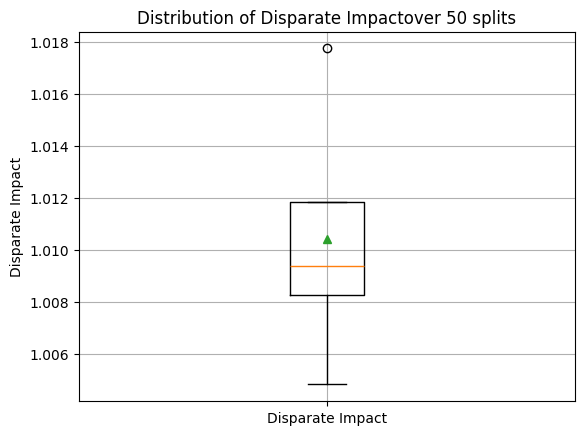

[0.9200276789244761, 0.9188414393040728, 0.9212139185448794, 0.9188414393040728, 0.918940292605773]


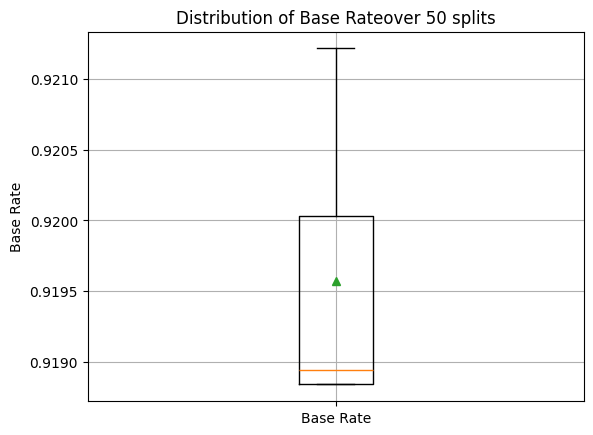

[0.010766555216715101, 0.007520511622836179, 0.016092634619558455, 0.008553296474644756, 0.004397068305078244]


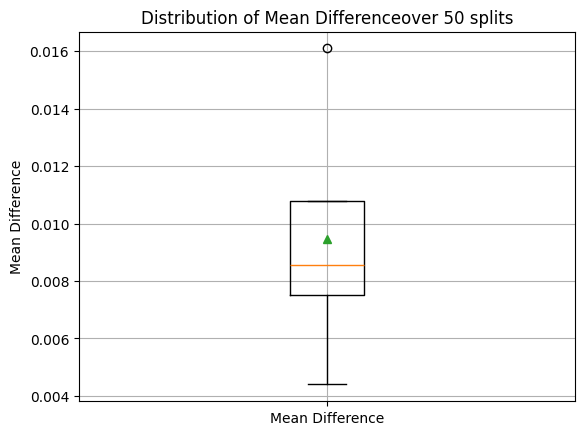

[809.0, 821.0, 797.0, 821.0, 820.0]


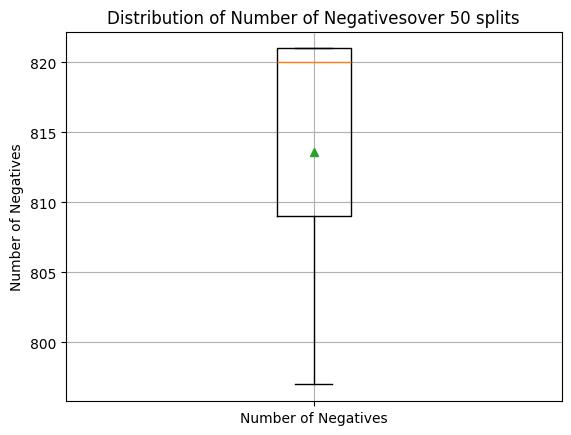

[0.010766555216715101, 0.007520511622836179, 0.016092634619558455, 0.008553296474644756, 0.004397068305078244]


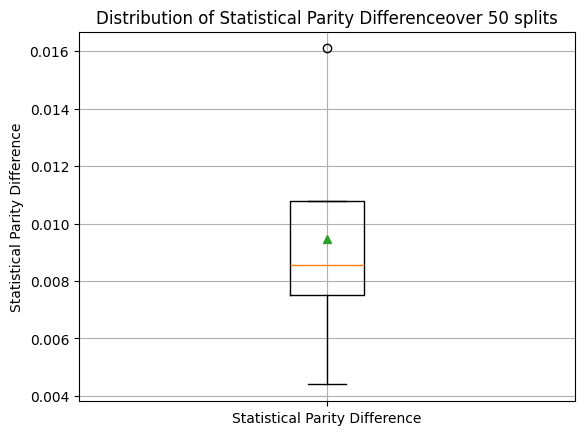

[0.0, 0.0, 0.0, 0.0, 0.0]


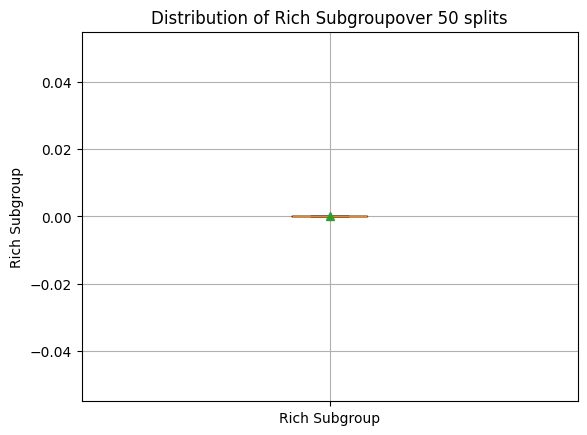

[0.9552194543297746, 0.961051799130091, 0.9518584420719652, 0.9529458283906682, 0.9602609727164887]


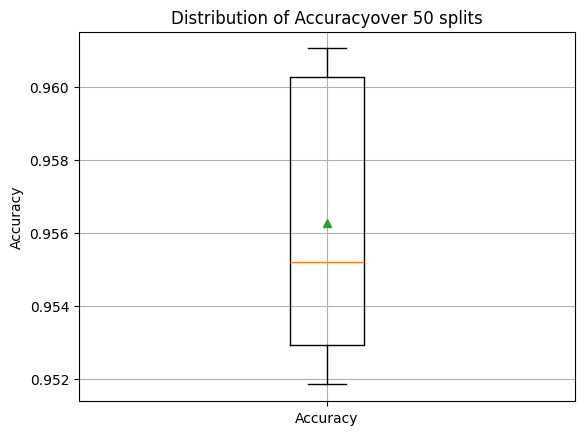

[0.9858210922770726]


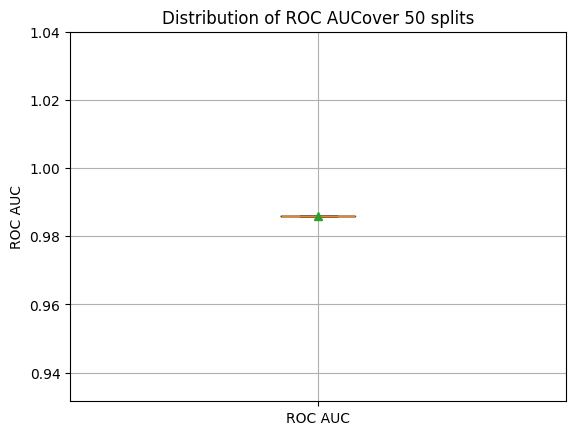

[0.7796052631578947]


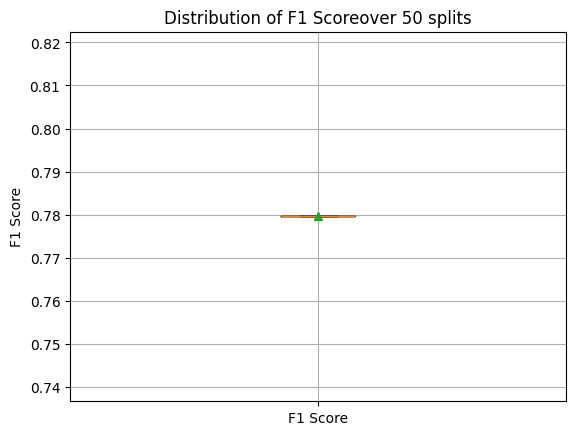

[0.8670731707317073]


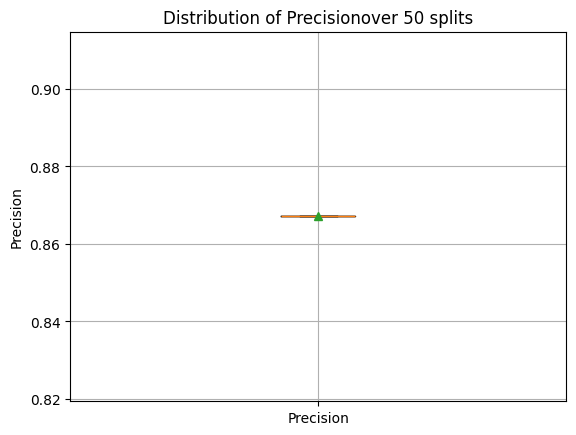

[0.7081673306772909]


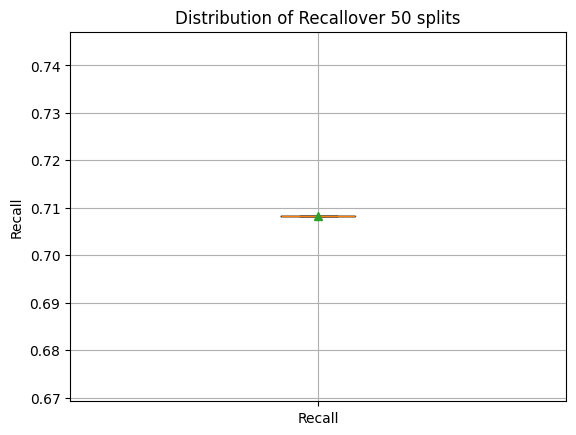

[[44910   610]
 [ 1602  3458]]


In [95]:
summarised_stats = {}
print(dict["Statistical Parity Difference"])
for key in dict:
  if key != "Confusion Matrix":
    summarised_stats[key] = {}
    summarised_stats[key]["mean"] = np.mean(dict[key])
    summarised_stats[key]["std"] = np.std(dict[key])
    summarised_stats[key]["min"] = np.min(dict[key])
    summarised_stats[key]["max"] = np.max(dict[key])
    summarised_stats[key]["median"] = np.median(dict[key])
  else:
    if "Confusion Matrix" not in summarised_stats:
      summarised_stats["Confusion Matrix"] = np.zeros((2,2), dtype=int)
    for i in range(len(dict[key])):
      summarised_stats["Confusion Matrix"] += dict[key][i]
print(len(dict["Accuracy"]))
print(summarised_stats["Confusion Matrix"])
print(summarised_stats["Statistical Parity Difference"])

for key in dict:
  if key != "Confusion Matrix":
    data = dict[key]
    print(data)
    plt.boxplot(data,
                labels=[key],
                showmeans=True)  # Show mean value
    
    plt.title('Distribution of ' + key + "over 50 splits")
    plt.ylabel(key)
    plt.grid(True)
    plt.show()
  
print(summarised_stats["Confusion Matrix"])


In [3]:
grid.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [6]:
y_pred = grid.predict(X_test)
original_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the original model: ', original_accuracy)

Accuracy of the original model:  0.9437065148640101


In [7]:
update_registered_converter(
    XGBClassifier,
    "XGBoostXGBClassifier",
    calculate_linear_classifier_output_shapes,
    convert_xgboost,
    options={"nocl": [True, False], "zipmap": [True, False, "columns"]},
)

In [8]:
booster = grid.best_estimator_["model"].get_booster()
original_feature_names = booster.feature_names
if original_feature_names is not None:
    onnx_converter_conform_feature_names = [f"f{num}" for num in range(len(original_feature_names))]
    booster.feature_names = onnx_converter_conform_feature_names

In [9]:
onnx_model = convert_sklearn(
    grid.best_estimator_, initial_types=[('X', FloatTensorType((None, X_train.shape[1])))],
    target_opset=12)

In [10]:
onnx.save(onnx_model, "model/model2.onnx")